# Introduction

In this notebook we just show off a little bit how the `RectMesh` class can be used to do some continuum modelling. 

The emphasis with this package is a low barrier to entry rather than extreme numerical efficiency. Thus it is good for proofs of concept and as a complementary tool for some more intense calculations (e.g. building a simple continuum model on top of DFT source data), but if you really want to do some heavy lifting you may need other tools.

At the time of writing all the tools assume that the mesh has periodic boundaries.

Note: The code for animating

In [1]:
from pyiron_base import Project
import pyiron_continuum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [2]:
pr = Project('scratch')
pr.remove_jobs(silently=True)

0it [00:00, ?it/s]

In [3]:
def animate(frames, n_contours=200):
    """
    A simple wrapper for animating a list of 2D images.
    
    Based on https://stackoverflow.com/questions/39472017/how-to-animate-the-colorbar-in-matplotlib
    """
    fig, ax = plt.subplots()

    cv0 = frames[0]

    vmax = np.max(cv0)
    vmin = np.min(cv0)
    levels = np.linspace(vmin, vmax, n_contours, endpoint=True)
    cf = ax.contourf(cv0, vmax=vmax, vmin=vmin, levels=levels)
    tx = ax.set_title(f'Frame 0: {np.linalg.norm(cv0):.2f}')
    fig.colorbar(cf)

    def animate_frames(i):
        arr = frames[i]
        cf = ax.contourf(arr, vmax=vmax, vmin=vmin, levels=levels)
        tx.set_text(f'Frame {i}: {np.linalg.norm(arr):.2f}')

    ani = animation.FuncAnimation(fig, animate_frames, frames=len(frames))

    return HTML(ani.to_jshtml())


def run(mesh, field, update_fnc, n_steps=1000, n_print=100, **update_fnc_kwargs):
    """
    A simple wrapper for updating a field on the mesh.
    """
    frames = []
    phi = np.array(field)
    
    for n in np.arange(n_steps):
        if n % n_print == 0:
            frames.append(np.array(phi))
        phi = update_fnc(mesh, phi, **update_fnc_kwargs)
            
    frames.append(np.array(phi))
    return frames

# Heat: $\frac{\partial \phi}{\partial t} = \nabla^2 \phi \rightarrow \phi(t+\Delta t) = (1 + \Delta t \nabla^2) \phi(t)$

In [4]:
mesh = pr.continuum.mesh.RectMesh([1, 1], 100)
potl = pr.continuum.schroedinger.potential.Sinusoidal(n_waves=3)
field0 = potl(mesh) + (np.random.rand(*mesh.divisions) - 0.5)  # Noisy sines

def heat(mesh, field, dt):
    return field + dt * mesh.laplacian(field)

heat_frames = run(mesh, field0, heat, n_steps=100, n_print=10, dt=1e-5)

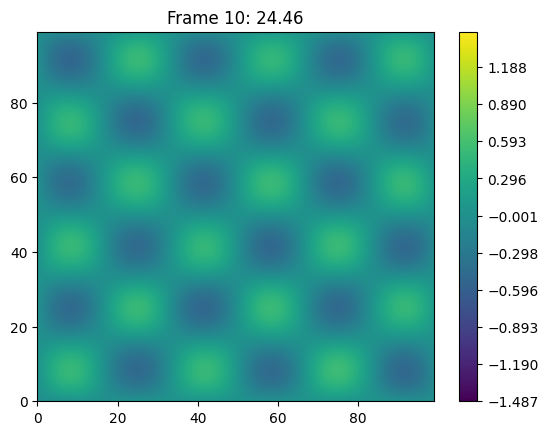

In [5]:
animate(heat_frames)

# Diffusion: $\frac{\partial \phi(r, t)}{\partial t} = \nabla \cdot(D(\phi, r) \nabla \phi(r, t))$

In [6]:
def D(mesh, field, **kwargs):
    """
    A very un-physically diffusivity that is zero whenever our field is non-positive.
    
    Will make a cool and easy-to-understand animation though!
    """
    return (field > 0).astype(float)

def diffusion(mesh, field, dt, diffusivity_fnc, **diffusivity_kwargs):
    return field + dt * mesh.div(D(mesh, field) * mesh.grad(field))

diff_frames = run(mesh, field0, diffusion, n_steps=200, n_print=10, dt=1e-5, diffusivity_fnc=D)

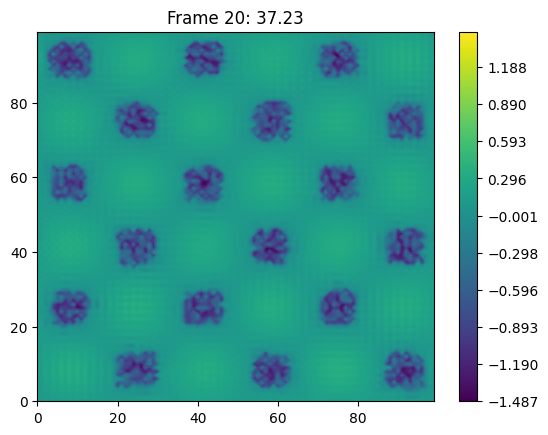

In [7]:
animate(diff_frames)

# Limitations

What makes `RectMesh` really easy to use is that it has lots of operations built in and immediately accessible. However, this comes with a word of caution: these generic implementations may expose you to numeric issues that a more bespoke implementation does not!

Let's look at an example I ran into while developing the code: the Laplacian operator. For a scalar field, $\phi$, we can can write the Laplacian in two equivalent ways: $\nabla^2 \phi = \nabla \cdot \nabla \phi = \sum_i \partial^2 \phi / \partial x_i^2$.

Now let's consider a specific case: calculating the Laplacian numerically using only two-point stencils. In the case of the definition with partials, we get the following: 

$(\nabla^2 \phi)_n = (\partial^2 \phi / \partial x^2) = (\phi_{n-1} -2 \phi_n + \phi_{n+1}) / \Delta x$

where $\Delta x$ is the spacing between two entries in our discretized $\phi$ vector. The final formulation is just the lowest-accuracy stensil for the second order derivative using the central difference method. In this 1d case, `mesh.laplacian(phi, accuracy=2)` and `mesh.derivative(phi, order=2, accuracy=2)[0]` both give you exactly this.

Now imagine that we had implemented the Laplacian by simply chaining together $\nabla \cdot \nabla$ -- i.e. `mesh.div(mesh.derivative(phi, order=1, accuracy=2), accuracy=2)`. What happens then? Since `mesh.div` is also just taking a sum over `mesh.derivative` outputs, we'd be chaining together two calls of the first-order derivative with the two point stencil. For our simple 1d example:

$(\nabla \cdot \nabla \phi)_n = (\partial_x \partial_x \phi)_n = (\partial_x (\phi_{n+1} - \phi_{n-1}) / 2\Delta x)_n = (\phi_{n+2} -2 \phi_n + \phi_{n-2}) / 4 \Delta x^2$

This is very similar and not incorrect, but note that in this formulation the Laplacian at location $n$ depends only on $n$'s *second* neighbours and not its first neighbours!

Below we'll see that this works fine when you're operating on very smooth and well-defined fields, but gives serious differences once noise is introduced. The first definition using the immediate neighbours is more robust.

In [8]:
mesh = pr.continuum.mesh.RectMesh(2 * np.pi, 100, accuracy=2)
phi = np.sin(mesh.mesh[0])

lap_phi_2nd = mesh.derivative(phi, order=2)[0]
lap_phi_chain = mesh.derivative(mesh.derivative(phi, order=1)[0], order=1)[0]

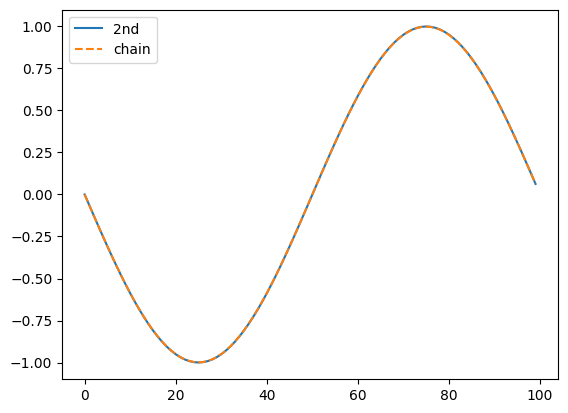

In [9]:
plt.plot(lap_phi_2nd, label='2nd')
plt.plot(lap_phi_chain, linestyle='--', label='chain')
plt.legend();
# Beautiful!

In [10]:
noisy_phi = phi + 0.01 * (np.random.rand(*phi.shape) - 0.5)
lap_nphi_2nd = mesh.derivative(noisy_phi, order=2, accuracy=2)[0]
lap_nphi_chain = mesh.derivative(mesh.derivative(noisy_phi, order=1, accuracy=2)[0], order=1, accuracy=2)[0]

In [11]:
plt.plot(lap_nphi_2nd, label='2nd')
plt.plot(lap_nphi_chain, linestyle='--', label='chain')
plt.legend();
# Do not agree!

In this case the variance away from the perfect sinusoid is pure noise, so in the chained operator case where we look at the *second* nearest neighbours at each point (and commensurately have a bigger $\Delta x$ prefactor in our denominator!) we *underestimate* the local curvature by introducing some artificial smoothing.

In fact, as we might suspect, one can get exactly the two-point stencil for second-order derivatives by chaining together two first derivatives ($\partial_x \partial_x$ had better equal $\partial_x^2$ after all!), but to do this we need to take step sizes of $\Delta x / 2$ for the first-order derivatives. Since our mesh does not, by definition, give us access to the field values at these half-points, we don't have this theoretical smaller-step first-order derivative available to us.

What is the impact? Well, we saw in the diffusion example above that we still can still run things by chaining our `div` and `derivative` operators, and we saw above that for smooth functions chaining or directly jumping to the second order partial are extremely similar. So for our diffusion example we might expect the result to be qualitatively OK the whole way along and quantitatively correct as things get smoother and smoother, but we should probably be cautious about ma